# Modelling Experiments

This notebook contain all the initial modelling experiments. A polished version of the best models can be found in 04_final_models_and_prediction.ipynb

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
from sklearn.model_selection import train_test_split

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.compose import ColumnTransformer

from sklearn.model_selection import cross_validate, StratifiedShuffleSplit, GridSearchCV

from sklearn.preprocessing import MinMaxScaler, OneHotEncoder, PolynomialFeatures
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer, SimpleImputer

from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from xgboost import XGBClassifier

from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

## Load the data

In [4]:
features = pd.read_csv("./../Training/X_train.csv")
labels = pd.read_csv("./../Training/y_train.csv")

In [5]:
print(f"The shape of training feature matrix is {features.shape}")
print(f"The shape of training labels is {labels.shape}")

The shape of training feature matrix is (33050, 44)
The shape of training labels is (33050, 2)


In [6]:
#Sanity check to see if the rows in X and y corresponds to the same entities
assert (features["Unique_ID"] == labels["Unique_ID"]).all()

## Train Test split

We need to set aside a portion of our training data to perform evaluations for selecting the best model. It is best to do it in the outset itself to avoid any data leakage or bias

In [7]:
y = labels["Dependent_Variable"]
X = features.drop("Unique_ID", axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, random_state=42, stratify=y) # Random state is set to ensure reproducibility

In [8]:
print(f"The shape of X_train is {X_train.shape}")
print(f"The shape of y_train is {y_train.shape}")
print()
print(f"The shape of X_test is {X_test.shape}")
print(f"The shape of y_test is {y_test.shape}")

The shape of X_train is (26440, 43)
The shape of y_train is (26440,)

The shape of X_test is (6610, 43)
The shape of y_test is (6610,)


## Preprocessing



In [9]:
# Categorical features
cat_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Numerical features
num_features = ['N1', 'N2', 'N3', 'N4', 'N5', 'N6', 'N7', 'N8',
                'N9', 'N10', 'N10.1', 'N11', 'N12', 'N14','N15',
                'N16', 'N17', 'N18', 'N19', 'N20', 'N21', 'N22',
                'N23', 'N24','N25', 'N26', 'N27', 'N28', 'N29',
                'N30', 'N31', 'N32', 'N33', 'N34','N35']

In [10]:
## Pipeline for categorical features

# select the categorical features from the input
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])

#OneHot encoding
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
                            ])

## Pipeline for numerical featurees

# select the numerical variables                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])

# Imputing for missing values, Scaling
num_transformers = Pipeline([('selector', select_num_features),
                            ('imputer', SimpleImputer()),
                            ('scaler', MinMaxScaler()),
                            ])

## combining both pipelines
preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', num_transformers),
                                ])

In [11]:
preprocess_pipe

FeatureUnion(transformer_list=[('cat',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('select_cat',
                                                                                  'passthrough',
                                                                                  ['C1',
                                                                                   'C2',
                                                                                   'C3',
                                                                                   'C4',
                                                                                   'C5',
                                                                                   'C6',
                                                                                   'C7',
                                                                                   'C8'])])),
                                                ('onehot',
                                                 OneHotEncoder(handle_unknown='infrequent_if_exist'))])),
                               ('num',
                                Pipeline(steps=[('selector',
                                                 ColumnTransformer(transformers=[('select_num',
                                                                                  'passthrough',
                                                                                  ['N1',
                                                                                   'N2',
                                                                                   'N3',
                                                                                   'N4',
                                                                                   'N5',
                                                                                   'N6',
                                                                                   'N7',
                                                                                   'N8',
                                                                                   'N9',
                                                                                   'N10',
                                                                                   'N10.1',
                                                                                   'N11',
                                                                                   'N12',
                                                                                   'N14',
                                                                                   'N15',
                                                                                   'N16',
                                                                                   'N17',
                                                                                   'N18',
                                                                                   'N19',
                                                                                   'N20',
                                                                                   'N21',
                                                                                   'N22',
                                                                                   'N23',
                                                                                   'N24',
                                                                                   'N25',
                                                                                   'N26',
                                                                                   'N27',
                                                                                   'N28',
                   

## Helper functions for training and evaluation

In [12]:
def train_model(model, X_train, y_train, cv=5):
    '''Trains the  model
    Args:
        model: Instance of the model to train
        X_train: Training data feature matrix
        y_train: Training data label vector
        cv: Cross validation Scheme
        
    Returns:
        trained model
        cv_results
    '''

    
    cv_results = cross_validate(model, X_train, y_train,
                                cv=cv,
                                scoring='roc_auc', 
                                return_train_score=True)

    mean_train_score = cv_results["train_score"].mean()
    mean_val_score = cv_results["test_score"].mean()
    
    std_train_score = cv_results["train_score"].std()
    std_val_score = cv_results["test_score"].std()

    print(f"Cross validated training results for the model")
    print(f"Train score: {mean_train_score} +/- {std_train_score}" )
    print(f"Validation score: {mean_val_score} +/- {std_val_score}" )

    trained_model = model.fit(X_train, y_train)

    return trained_model, cv_results

def evaluate_model(model, X_test, y_test):

    '''Evaluates the  model
    Args:
        fitted_model: Instance of the model to train
        X_test: Test data feature matrix
        y_test: Test data label vector
        
    Returns:
        metrics: A dictionary containing auc_roc score, accuracy, fpr and tpr
    '''
    y_pred = model.predict(X_test)
    y_scores = model.predict_proba(X_test)[:, 1]

    auc = roc_auc_score(y_test, y_scores)
    acc = accuracy_score(y_test, y_pred)
    fpr, tpr, _ = roc_curve(y_test, y_scores)
    print("AUC-ROC score on test set: ", auc)
    print("Accuracy score on test set: ", acc)
    metrics = {"auc_roc": auc, "accuracy": acc, "fpr": fpr, "tpr": tpr}
    
    return metrics

def tune_model(model, param_grid, cv=5):
    '''Do hyper parameter tuning using GridSearch strategy
    
        Args:
            model: Model to be tuned
            param_grid: dict of parameters
            X_train: Feature matrix
            y_train: Label matrix
        
        Returns: 
            best parameters
            best estimator
        '''

    search = GridSearchCV(model, param_grid = param_grid,
                        cv = cv,
                        scoring='roc_auc',
                        return_train_score=True)
    
    search.fit(X_train, y_train)

    best_model = search.best_estimator_
    cv_results = search.cv_results_
    
    print("Best parameters: ", search.best_params_)
    
    print("-------------------Best model performance --------------------------")
    
    mean_train_score = search.cv_results_['mean_train_score'][search.best_index_]
    mean_val_score = search.cv_results_['mean_test_score'][search.best_index_]
    std_train_score = search.cv_results_['std_train_score'][search.best_index_]
    std_val_score = search.cv_results_['std_test_score'][search.best_index_]

    print(f"Score of the model on the train set:\n"
         f"{mean_train_score:.3f} +/- {std_train_score:.6f}")

    print(f"Score of the model on the validation set:\n"
        f"{mean_val_score:.3f} +/- {std_val_score:.6f}")
    
    
    
    return best_model, cv_results

def compare_models(model_list, preprocess_pipe, cv):
    '''Compare a list of models defined in model_list and return the auc, fpr and tpr
        Args:
            model_list: List of models to compare. Must be a list of dictionaries with keys;
                            name - name of the model
                            model - an instance of the estimator,
                            param_grid - hyper parameter grid for hp tuning with gridsearch

            preprocess_pipe: Pipeline object for preprocessing
            cv: cross validation scheme

        Returns:
            logged_metrics: A dictionary with model names as keys
    '''
    logged_metrics = {}
    for model in model_list:
        model_name = model["name"]
        print(f"Training {model_name} model...")
        model_pipe = Pipeline([('preprocess', preprocess_pipe),
                                ('model', model["model"])])
        
        print(f"Tuning hyper parameters...")
        
        param_grid = model["param_grid"]
        tuned_model, _ = tune_model(model_pipe, param_grid, cv=cv)
        metrics = evaluate_model(tuned_model, X_test, y_test)

        #store metrics for later use
        logged_metrics[model_name] = metrics

    return logged_metrics


## Cross validation scheme

In [13]:
cv = StratifiedShuffleSplit(n_splits=5, test_size=0.2, random_state=42)

## Initial models

### Naive baseline

In [14]:
# Let's initialise a dictionary to store all the metrics obtained from the models
logged_metrics = {}

In [14]:
dummy_pipe = Pipeline([('preprocess', preprocess_pipe),
                        ('model', DummyClassifier(strategy='stratified', random_state=42))])

In [15]:
print("Training Naive Baseline...")
dummy_fitted, cv_results = train_model(dummy_pipe, X_train, y_train, cv=cv)
print("Evaluating the Baseline model...")
metrics = evaluate_model(dummy_fitted, X_test, y_test)

#store metrics for later use
logged_metrics["Naive Baseline"] = metrics

Training Naive Baseline...
Cross validated training results for the model
Train score: 0.5003637024669877 +/- 0.002979375088074111
Validation score: 0.5024052481187009 +/- 0.004367380364923145
Evaluating the Baseline model...
AUC-ROC score on test set:  0.49906544852197715
Accuracy score on test set:  0.5741301059001512


In [13]:
model_list = [{"name": "Logistic Regression",
                "model": LogisticRegression(max_iter=2000, solver = 'saga', random_state=42),
                "param_grid": {"model__C": [0.001, 0.1, 1, 10, 100],
                                "model__penalty": ['l1', 'l2']}
            },

            {"name": "Decision tree",
            "model": DecisionTreeClassifier(random_state=42),
            "param_grid": {"model__max_depth": [5, 10, 15, 20],
                            "model__min_samples_split": range(2, 10, 2),
                            "model__min_samples_leaf": range(1, 5)}
            },
            
            {"name": "Random Forest",
            "model": RandomForestClassifier(random_state=42),
            "param_grid": {"model__max_depth": [5, 10, 15, 20, None],
                            "model__n_estimators": [100, 200, 300]}
            },

            {"name": "XGBoost",
            "model": XGBClassifier(random_state=42),
            "param_grid": {"model__max_depth": [5, 10, 15, 20, None],
                            "model__n_estimators": [100, 200, 300]}
            }


        ]

In [17]:
logged_metrics = compare_models(model_list, preprocess_pipe, cv)

Training Logistic Regression model...
Tuning hyper parameters...
Best parameters:  {'model__C': 10, 'model__penalty': 'l1'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.770 +/- 0.000482
Score of the model on the validation set:
0.760 +/- 0.002444
AUC-ROC score on test set:  0.7611434406228454
Accuracy score on test set:  0.7440242057488654
Training Decision tree model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.727 +/- 0.000974
Score of the model on the validation set:
0.714 +/- 0.002650
AUC-ROC score on test set:  0.711410021029821
Accuracy score on test set:  0.7190620272314675
Training Random Forest model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': None, 'model__n_estimators': 300}
-------------------Be

### Comparison of models so far

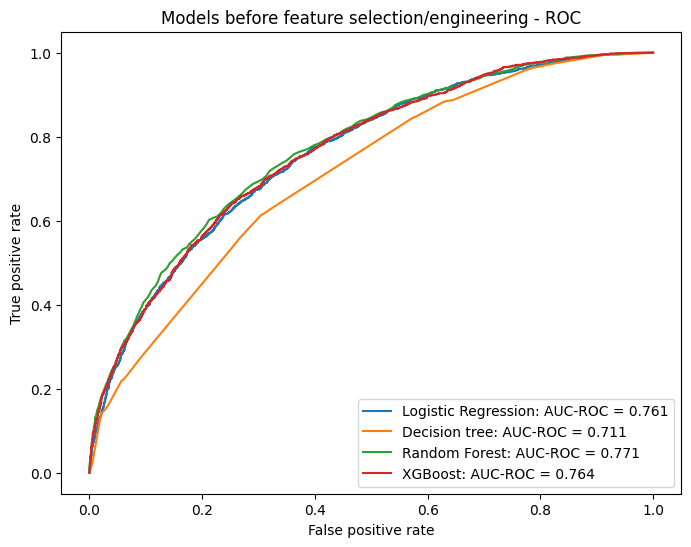

In [18]:
def plot_roc_comparison(logged_metrics, title):
    plt.figure(figsize=(8, 6))
    for model in logged_metrics.keys():
        metrics = logged_metrics[model]
        auc = metrics["auc_roc"]
        label = f"{model}: AUC-ROC = {auc:.3f}"
        plt.plot(metrics["fpr"], metrics["tpr"], label=label)

    plt.title(title)
    plt.xlabel("False positive rate")
    plt.ylabel("True positive rate")
    plt.legend()
    plt.show()

plot_roc_comparison(logged_metrics, "Models before feature selection/engineering - ROC")

Random forest based model seems to be the best at the moment. But XGBoost and Logistic Regression also gives comparable performance

## Manual Feature Elimination

Let's try and use the insights from EDA to select features. The following criteria are used to remove some features

* Highly correlated features are removed.
* Features with more than 80% missing values are removed

In [19]:
# Categorical features
cat_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Numerical features -> N5 - N8 & N20, N27 removed because of high correlation. 
#                       N25 - N32 removed due to large number of missing values

num_features = ['N1', 'N2', 'N3', 'N4', 'N9', 'N10', 'N10.1', 'N11', 
                'N12', 'N14','N15','N16', 'N17', 'N18', 'N19', 'N20',
                 'N21', 'N22', 'N23', 'N24', 'N33', 'N34','N35']

Preprocessing is left the same as before

In [20]:
## Pipeline for categorical features

# select the categorical features from the input
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])

#OneHot encoding
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
                            ])

## Pipeline for numerical featurees

# select the numerical variables                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])

# Imputing for missing values, Scaling
num_transformers = Pipeline([('selector', select_num_features),
                            ('imputer', SimpleImputer()),
                            ('scaler', MinMaxScaler()),
                            ])

## combining both pipelines
preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', num_transformers),
                                ])

In [21]:
logged_metrics = compare_models(model_list, preprocess_pipe, cv)

Training Logistic Regression model...
Tuning hyper parameters...
Best parameters:  {'model__C': 10, 'model__penalty': 'l1'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.767 +/- 0.000462
Score of the model on the validation set:
0.757 +/- 0.002839
AUC-ROC score on test set:  0.7581507311967224
Accuracy score on test set:  0.7405446293494705
Training Decision tree model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 1, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.727 +/- 0.001118
Score of the model on the validation set:
0.713 +/- 0.003249
AUC-ROC score on test set:  0.711410021029821
Accuracy score on test set:  0.7190620272314675
Training Random Forest model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': None, 'model__n_estimators': 300}
-------------------Be

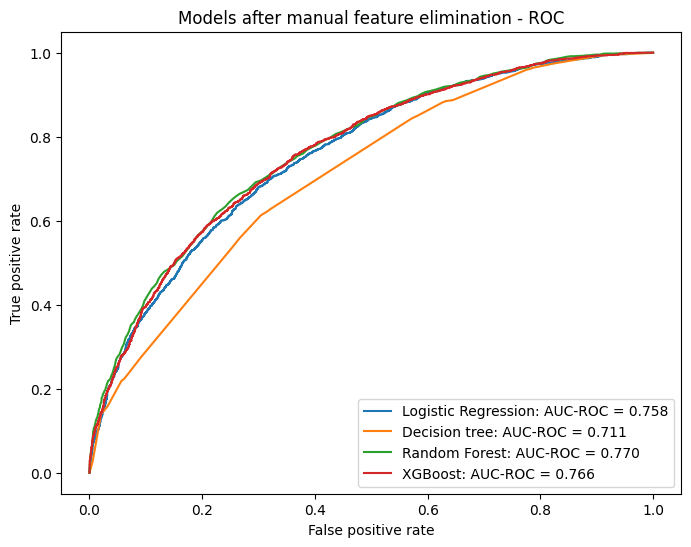

In [22]:
plot_roc_comparison(logged_metrics, "Models after manual feature elimination - ROC")

## Introducing interaction terms

In [26]:
## Pipeline for categorical features

# select the categorical features from the input
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])

#OneHot encoding
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
                            ])

## Pipeline for numerical featurees

# select the numerical variables                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])

# Imputing for missing values, Scaling
num_transformers = Pipeline([('selector', select_num_features),
                            ('imputer', SimpleImputer()),
                            ('poly', PolynomialFeatures(degree=2, interaction_only=True)),
                            ('scaler', MinMaxScaler()),
                            ])

## combining both pipelines
preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', num_transformers),
                                ])

In [27]:
logged_metrics = compare_models(model_list, preprocess_pipe, cv)

Training Logistic Regression model...
Tuning hyper parameters...


/home/viswajith/.local/share/virtualenvs/DS_Test-tmAUNUap/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/DS_Test-tmAUNUap/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/DS_Test-tmAUNUap/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/DS_Test-tmAUNUap/lib/python3.10/site-packages/sklearn/linear_model/_sag.py:350: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  warnings.warn(
/home/viswajith/.local/share/virtualenvs/DS_Test-tmAUNUap/lib/python3.10/site-packages/sklearn/linear_model/_sag

Best parameters:  {'model__C': 10, 'model__penalty': 'l2'}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.780 +/- 0.000578
Score of the model on the validation set:
0.763 +/- 0.002031
AUC-ROC score on test set:  0.7639365860443101
Accuracy score on test set:  0.7441754916792739
Training Decision tree model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': 5, 'model__min_samples_leaf': 4, 'model__min_samples_split': 2}
-------------------Best model performance --------------------------
Score of the model on the train set:
0.731 +/- 0.002546
Score of the model on the validation set:
0.711 +/- 0.005377
AUC-ROC score on test set:  0.715701451391152
Accuracy score on test set:  0.7217851739788199
Training Random Forest model...
Tuning hyper parameters...
Best parameters:  {'model__max_depth': 15, 'model__n_estimators': 300}
-------------------Best model performance --------------------------
Score of the model 

Some of the models haven't converged. We can try increasing max_iter, but since only marginal improvement is expected, it might be better to leave it for now in the interest of time.

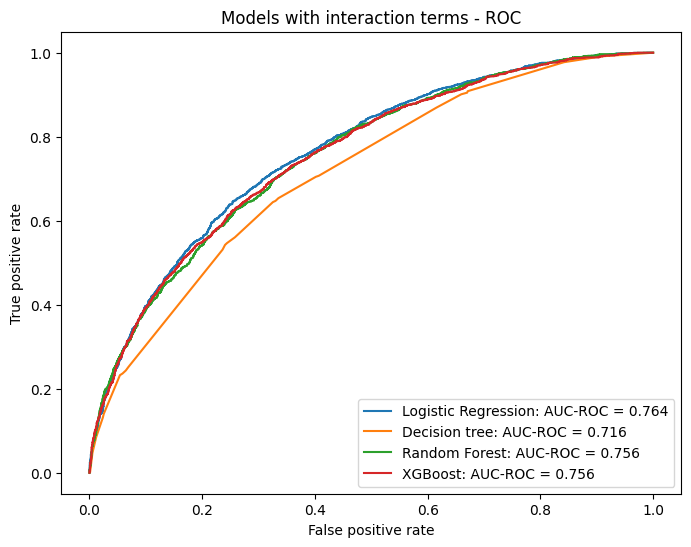

In [28]:
plot_roc_comparison(logged_metrics, "Models with interaction terms - ROC")

## Tackling Class imbalance

Let's try using SMOTE for rectifying the class imbalance in the problem

In [15]:
from imblearn.over_sampling import SMOTENC
from imblearn.pipeline import Pipeline

In [16]:
# Categorical features
cat_features = ['C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8']

# Numerical features -> N5 - N8 & N20, N27 removed because of high correlation. 
#                       N25 - N32 removed due to large number of missing values

num_features = ['N1', 'N2', 'N3', 'N4', 'N9', 'N10', 'N10.1', 'N11', 
                'N12', 'N14','N15','N16', 'N17', 'N18', 'N19', 'N20',
                 'N21', 'N22', 'N23', 'N24', 'N33', 'N34','N35']

Preprocessing is left the same as before

In [17]:
## Pipeline for categorical features

# select the categorical features from the input
select_cat_features = ColumnTransformer([('select_cat', 'passthrough', cat_features)])

#OneHot encoding
cat_transformers = Pipeline([('selector', select_cat_features),
                            ('onehot', OneHotEncoder(handle_unknown='infrequent_if_exist')),
                            ])

## Pipeline for numerical featurees

# select the numerical variables                            
select_num_features = ColumnTransformer([('select_num', 'passthrough', num_features)])

# Imputing for missing values, Scaling
num_transformers = Pipeline([('selector', select_num_features),
                            ('imputer', SimpleImputer()),
                            ('scaler', MinMaxScaler()),
                            ])

## combining both pipelines
preprocess_pipe = FeatureUnion([('cat', cat_transformers),
                                ('num', num_transformers),
                                ])

In [18]:
X_train_preprocessed = preprocess_pipe.fit_transform(X_train)
X_test_preprocessed = preprocess_pipe.transform(X_test)

In [19]:
n_cat_features = X_train_preprocessed.shape[1] - len(num_features)
n_cat_features

164

In [20]:
model_pipe = Pipeline([("preprocessing", preprocess_pipe),
                        ("oversample", SMOTENC(categorical_features=list(range(n_cat_features)), random_state=42)),
                        ("model", RandomForestClassifier(random_state=42))])

In [21]:
trained_model, _ = train_model(model_pipe, X_train, y_train, cv=cv)


Cross validated training results for the model
Train score: 1.0 +/- 0.0
Validation score: 0.7504035190743581 +/- 0.002583456746904203


AttributeError: 'function' object has no attribute 'predict'

In [22]:
metrics = evaluate_model(trained_model, X_test, y_test)

AUC-ROC score on test set:  0.7584465920719795
Accuracy score on test set:  0.7358547655068078
